In [24]:
import xarray as xr 

# Maths Servers

In [25]:
# import sys
# sys.path.append('/home/links/ct715/eddy_feedback')
# import functions.eddy_feedback as ef 

# ds = xr.open_mfdataset('/home/links/ct715/eddy_feedback/daily_datasets/jra55_djf_ep.nc',
#                             parallel=True, chunks={'time': 31})
# ds

# JASMIN Server

In [26]:
import sys
sys.path.append('/home/users/cturrell/documents/eddy_feedback')
import functions.eddy_feedback as ef 

ds = xr.open_mfdataset('/home/users/cturrell/documents/eddy_feedback/daily_datasets/jra55_djf_ubar_div1.nc',
                            parallel=True, chunks={'time': 31})

# # TEM SPARC Reanalysis
# ds = xr.open_mfdataset('/gws/nopw/j04/arctic_connect/cturrell/eddy_feedback/reanalysis/jra55/*.nc') 

ds

<xarray.Dataset>
Dimensions:  (time: 5325, level: 37, lat: 73)
Coordinates:
  * time     (time) datetime64[ns] 1958-01-01T09:00:00 ... 2016-12-31T09:00:00
  * lat      (lat) float64 90.0 87.5 85.0 82.5 80.0 ... -82.5 -85.0 -87.5 -90.0
  * level    (level) float64 1.0 2.0 3.0 5.0 7.0 ... 925.0 950.0 975.0 1e+03
Data variables:
    ubar     (time, level, lat) float32 dask.array<chunksize=(31, 37, 73), meta=np.ndarray>
    div1     (time, level, lat) float64 dask.array<chunksize=(31, 37, 73), meta=np.ndarray>

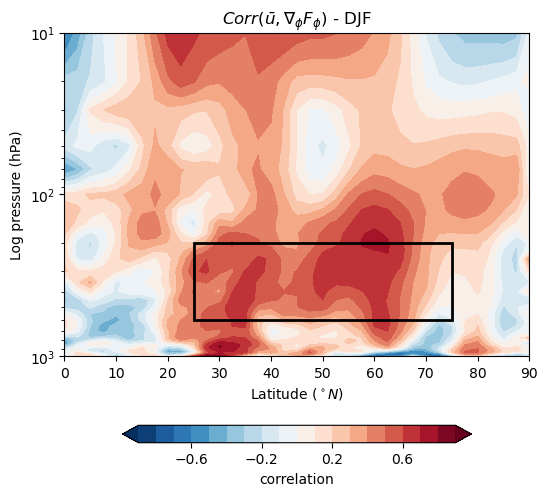

In [27]:
ef.correlation_contourf(ds)

In [28]:
def calculate_ef_parameter(ds, primitive=True, hemisphere='NH', reanalysis=True,
                           whole_area=True, which_level=None, rename_variables=False):

    """ 
    Input: Xarray dataset

    Output: Xarray dataArray of Eddy Feedback Parameter (EFP)
    """

    ## CONDITIONS
    
    # if required, rename variables
    if rename_variables:
        ds = ef.find_rename_variables(ds) 


    # Reduce dataset to 200-600hPa
    ds = ds.where( ds.level >= 200., drop=True ) 
    ds = ds.where( ds.level <= 600., drop=True ) 

    # choose hemisphere
    if hemisphere == 'SH':
        # set southern hermisphere
        ds = ds.where( ds.lat <= 0, drop=True )
    else:
        # set northern hemisphere
        ds = ds.where( ds.lat >= 0, drop=True )


    #-------------------------------------------------------------------

    ## SET UP TIME
    
    # # remove unwanted variables
    # vars = ['u', 'div1', 'div2']
    # ds = ds[vars]
    
    # set variables and save them
    ubar = ds.ubar
    div1 = ds.div1
    # div2 = ds.div2
    
    if reanalysis: 
        # separate time into annual means
        # and use .load() to force the calculation now
        ubar = ubar.groupby('time.year').mean('time').load()
        div1 = div1.groupby('time.year').mean('time').load()
        # div2 = div2.groupby('time.year').mean('time').load()
    else:
        # separate time into annual means
        ubar = ubar.load()
        div1 = div1.load()
        # div2 = div2.load()

    # calculate Pearson's correlation
    R = xr.corr(div1, ubar, dim='year')

    


    # choose between whole area or individual levels
    if whole_area: 
        # average over 200-600hPa
        R = R.mean(('level'))
    else:
        # take a slice at particular level
        R = R.sel( level = which_level)

    # calculate correlation squared (R^2)
    R = R**2


    return R

In [29]:
R = calculate_ef_parameter(ds, whole_area=False, which_level=500)
R

<xarray.DataArray (lat: 37)>
array([3.98460238e-04, 1.35809419e-02, 4.69312393e-02, 3.04861564e-05,
       5.15407160e-03, 3.81765143e-03, 4.12081167e-05, 1.12872633e-04,
       3.11208404e-02, 1.30909960e-01, 2.40787246e-01, 3.57719350e-01,
       3.90621568e-01, 2.60540085e-01, 1.74863480e-01, 1.99294352e-01,
       2.95425551e-01, 3.01305558e-01, 2.45388351e-01, 2.32539284e-01,
       1.76749351e-01, 2.06060484e-01, 4.21796849e-01, 4.25675851e-01,
       3.13915308e-01, 2.42996076e-01, 1.83629589e-01, 1.38133931e-01,
       5.62253841e-02, 3.57668153e-03, 7.71904541e-02, 1.07751810e-01,
       1.22256071e-01, 7.40646278e-02, 3.41732804e-02, 6.43931461e-02,
       4.95746516e-02])
Coordinates:
  * lat      (lat) float64 90.0 87.5 85.0 82.5 80.0 ... 10.0 7.5 5.0 2.5 0.0
    level    float64 500.0

In [30]:
import numpy as np
RR = R*np.cos( np.deg2rad(ds.lat) )

RR = RR.sel(lat=slice(72,25))

RR

<xarray.DataArray (lat: 19)>
array([0.01064395, 0.05009707, 0.10176109, 0.16517641, 0.19531078,
       0.13998809, 0.10029757, 0.12132271, 0.18989588, 0.20355908,
       0.17351577, 0.17144594, 0.13539786, 0.16347877, 0.34551575,
       0.35901137, 0.27185863, 0.21554015, 0.16642493])
Coordinates:
  * lat      (lat) float64 70.0 67.5 65.0 62.5 60.0 ... 35.0 32.5 30.0 27.5 25.0
    level    float64 500.0

In [31]:
R_weighted = RR.sum('lat') / (np.cos( np.deg2rad(ds.lat) )).sum('lat')
R_weighted.values

array(0.07157513)

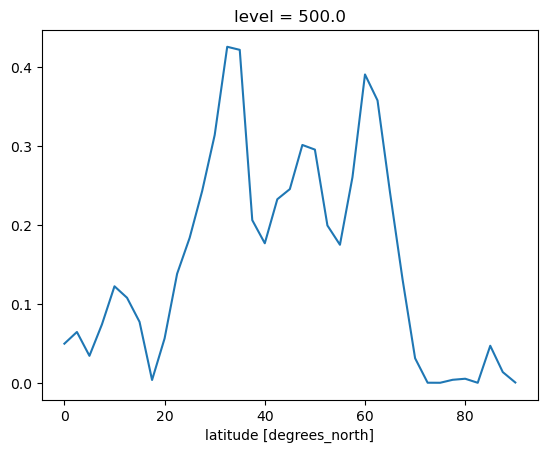

In [32]:
R.plot.line()

# SPARC Reanalysis 

In [33]:
# # TEM SPARC Reanalysis
ds = xr.open_mfdataset('/gws/nopw/j04/arctic_connect/cturrell/eddy_feedback/reanalysis/jra55/*.nc')

div1 = ds.EPFD_phi_pr
div1

<xarray.DataArray 'EPFD_phi_pr' (time: 708, pressure: 22, latitude: 73)>
dask.array<concatenate, shape=(708, 22, 73), dtype=float32, chunksize=(1, 22, 73), chunktype=numpy.ndarray>
Coordinates:
  * time      (time) datetime64[ns] 1958-01-14T09:00:00 ... 2016-12-14T09:00:00
  * pressure  (pressure) float32 1e+03 925.0 850.0 700.0 ... 5.0 3.0 2.0 1.0
  * latitude  (latitude) float32 -90.0 -87.5 -85.0 -82.5 ... 82.5 85.0 87.5 90.0
Attributes:
    standard_name:  tendency_of_eastward_wind_due_to_eliassen_palm_flux_diver...
    units:          m s-2
    description:    Uses primitive equation
    wavenumber:     
    cell_methods:   time: mean

In [34]:
ds = xr.open_mfdataset('/badc/srip/data/zonal/common_grid/jra_55/ZMD_monthly*.nc')

ubar = ds.u
ubar

<xarray.DataArray 'u' (time: 708, pressure: 22, latitude: 73)>
dask.array<concatenate, shape=(708, 22, 73), dtype=float32, chunksize=(1, 22, 73), chunktype=numpy.ndarray>
Coordinates:
  * time      (time) datetime64[ns] 1958-01-14T09:00:00 ... 2016-12-14T09:00:00
  * pressure  (pressure) float32 1e+03 925.0 850.0 700.0 ... 5.0 3.0 2.0 1.0
  * latitude  (latitude) float32 -90.0 -87.5 -85.0 -82.5 ... 82.5 85.0 87.5 90.0
Attributes:
    standard_name:  eastward_wind
    units:          m s-1
    description:    Zonal average of eastward wind
    cell_methods:   time: mean

In [35]:
ds = xr.Dataset(data_vars={'ubar': ubar, 'div1': div1})
ds

<xarray.Dataset>
Dimensions:   (time: 708, pressure: 22, latitude: 73)
Coordinates:
  * time      (time) datetime64[ns] 1958-01-14T09:00:00 ... 2016-12-14T09:00:00
  * pressure  (pressure) float32 1e+03 925.0 850.0 700.0 ... 5.0 3.0 2.0 1.0
  * latitude  (latitude) float32 -90.0 -87.5 -85.0 -82.5 ... 82.5 85.0 87.5 90.0
Data variables:
    ubar      (time, pressure, latitude) float32 dask.array<chunksize=(1, 22, 73), meta=np.ndarray>
    div1      (time, pressure, latitude) float32 dask.array<chunksize=(1, 22, 73), meta=np.ndarray>

In [36]:
rename = {'latitude': 'lat', 'pressure':'level'}
ds = ds.rename(rename)
ds

<xarray.Dataset>
Dimensions:  (time: 708, level: 22, lat: 73)
Coordinates:
  * time     (time) datetime64[ns] 1958-01-14T09:00:00 ... 2016-12-14T09:00:00
  * level    (level) float32 1e+03 925.0 850.0 700.0 600.0 ... 5.0 3.0 2.0 1.0
  * lat      (lat) float32 -90.0 -87.5 -85.0 -82.5 -80.0 ... 82.5 85.0 87.5 90.0
Data variables:
    ubar     (time, level, lat) float32 dask.array<chunksize=(1, 22, 73), meta=np.ndarray>
    div1     (time, level, lat) float32 dask.array<chunksize=(1, 22, 73), meta=np.ndarray>

In [37]:
import datetime as dt 

ds = ds.sel(time=ds.time.dt.month.isin([12,1,2]))
ds

<xarray.Dataset>
Dimensions:  (time: 177, level: 22, lat: 73)
Coordinates:
  * time     (time) datetime64[ns] 1958-01-14T09:00:00 ... 2016-12-14T09:00:00
  * level    (level) float32 1e+03 925.0 850.0 700.0 600.0 ... 5.0 3.0 2.0 1.0
  * lat      (lat) float32 -90.0 -87.5 -85.0 -82.5 -80.0 ... 82.5 85.0 87.5 90.0
Data variables:
    ubar     (time, level, lat) float32 dask.array<chunksize=(1, 22, 73), meta=np.ndarray>
    div1     (time, level, lat) float32 dask.array<chunksize=(1, 22, 73), meta=np.ndarray>

In [38]:
import matplotlib.pyplot as plt
import numpy as np

import functions.eddy_feedback as ef

def correlation_contourf(ds, label='DJF', top_atmos=10., reanalysis=True, hemisphere='NH',
                         show_div2=False, logscale=True, show_rect=True, primitive=True,
                         rename_variables=False):
    
    """"
    Input: dataset that contains ep fluxes data
            - with variables: (time, level, lat, lon)
    
    Output: contourf plot matching Fig.6 in Smith et al., 2022 
    """
    
    ## CONDITIONS
    
    # if required, rename variables
    if rename_variables:
        ds = ef.find_rename_variables(ds) 
        
    # choose hemisphere
    if hemisphere == 'SH':
        # set southern hermisphere
        ds = ds.where( ds.lat <= 0, drop=True )
    else:
        # set northern hemisphere
        ds = ds.where( ds.lat >= 0, drop=True )
    
    # cut off stratosphere
    ds = ds.where( ds.level >= top_atmos, drop=True )
    
    #------------------------------------------------------------------
    
    ## SET UP TIME
    
    # set variables and save them
    ubar = ds.ubar
    div1 = ds.div1
    
    if reanalysis == True:
        # separate time into annual means
        # and use .load() to force the calculation now
        ubar = ubar.groupby('time.year').mean('time').load()
        div1 = div1.groupby('time.year').mean('time').load()
    else:
        # separate time into annual means
        ubar = ubar.load()
        div1 = div1.load()
    
    # choose which variable; default: div1
    if show_div2==True:
        if reanalysis == True:
            corr = xr.corr(ubar, div2, dim='year') 
        else:
            corr = xr.corr(ubar, div2, dim='time')
        title_name = '\\nabla_p F_p'
        figgy = (6,7)
    else:
        if reanalysis == True:
            corr = xr.corr(ubar, div1, dim='year')
        else:
            corr = xr.corr(ubar, div1, dim='time')
        title_name = '\\nabla_{\\phi} F_{\\phi}'
        figgy = (6,6)
        
    import matplotlib.patches as patches

    plt.figure(figsize=figgy)

    plt.contourf(ds.lat.values, ds.level.values, corr, cmap='RdBu_r', levels=np.linspace(-0.9,0.9,19),
             extend='both')
    plt.colorbar(location='bottom', orientation='horizontal', shrink=0.75, label='correlation',
             extend='both', ticks=[-0.6,-0.2,0.2,0.6])
    plt.gca().invert_yaxis() 
    
    if logscale==True:
        plt.yscale('log')
        

    plt.xlabel('Latitude $(^\\circ N)$')
    plt.ylabel('Log pressure (hPa)')
    plt.title('$Corr(\\bar{{u}}, {0})$ - {1}'.format(title_name, label))

    if show_rect == True:
        rect = patches.Rectangle((25., 600.), 50, -400, 
                         fill=False, linewidth=2)
        plt.gca().add_patch(rect)

    plt.show() 

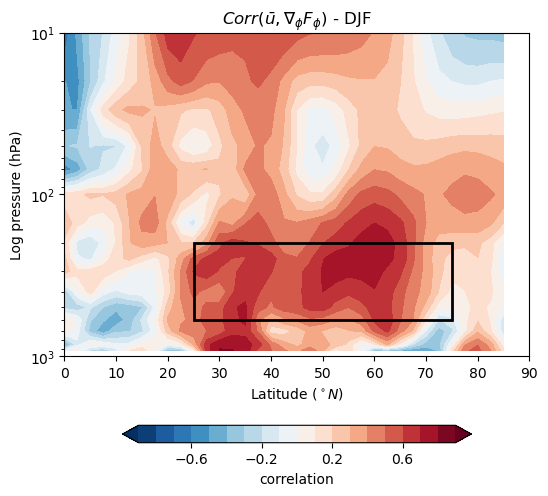

In [39]:
correlation_contourf(ds)

In [40]:
# ds.to_netcdf('/gws/nopw/j04/arctic_connect/cturrell/eddy_feedback/reanalysis/jra55_TEM_ubar_div1.nc')

In [41]:
ds.level

<xarray.DataArray 'level' (level: 22)>
array([1000.,  925.,  850.,  700.,  600.,  500.,  400.,  300.,  250.,  200.,
        150.,  100.,   70.,   50.,   30.,   20.,   10.,    7.,    5.,    3.,
          2.,    1.], dtype=float32)
Coordinates:
  * level    (level) float32 1e+03 925.0 850.0 700.0 600.0 ... 5.0 3.0 2.0 1.0
Attributes:
    description:    Pressure levels
    standard_name:  air_pressure
    units:          hPa

In [48]:
RR = calculate_ef_parameter(ds)
RR 

<xarray.DataArray (lat: 37)>
array([1.89410136e-03, 3.77905838e-03, 7.27762647e-03, 1.00144568e-02,
       1.00208070e-02, 1.83465510e-03, 2.17027620e-04, 2.42362880e-03,
       5.12267079e-02, 1.29679945e-01, 2.09810701e-01, 2.86876191e-01,
       3.07895838e-01, 3.92260667e-01, 4.45073660e-01, 3.44805322e-01,
       2.59255143e-01, 2.42707861e-01, 2.59198360e-01, 3.39388365e-01,
       4.02213646e-01, 3.89806907e-01, 3.74076606e-01, 4.14344703e-01,
       4.78718524e-01, 4.62955666e-01, 3.48621211e-01, 2.12845700e-01,
       8.93615521e-02, 1.53608079e-02, 5.63205775e-03, 1.62914470e-02,
       3.35378553e-02, 1.19149341e-02, 3.32400432e-03,            nan,
                  nan])
Coordinates:
  * lat      (lat) float32 0.0 2.5 5.0 7.5 10.0 ... 80.0 82.5 85.0 87.5 90.0

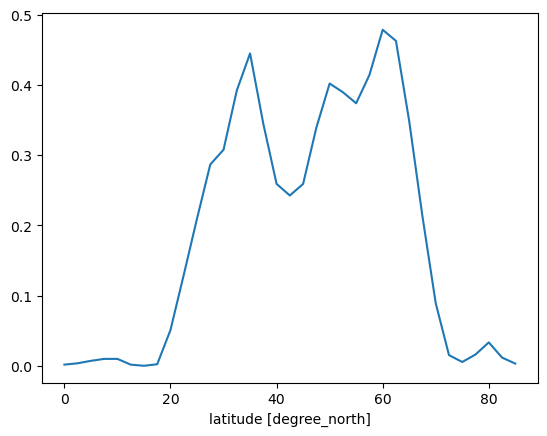

In [49]:
RR.plot()

In [50]:
import numpy as np
RR = RR*np.cos( np.deg2rad(ds.lat) )

RR = RR.sel(lat=slice(25,72))

RR



<xarray.DataArray (lat: 19)>
array([0.19015307, 0.25446228, 0.26664561, 0.33082928, 0.364583  ,
       0.27355245, 0.19860096, 0.178943  , 0.18328091, 0.22928746,
       0.25853796, 0.23729941, 0.21456153, 0.22262723, 0.23935925,
       0.21376913, 0.14733368, 0.08145252, 0.03056345])
Coordinates:
  * lat      (lat) float32 25.0 27.5 30.0 32.5 35.0 ... 60.0 62.5 65.0 67.5 70.0

In [53]:
R_weighted = RR.sum('lat') / (np.cos( np.deg2rad(ds.lat) )).sum('lat')
R_weighted.values**0.5

0.2996798282998763

In [52]:
R = np.sqrt(RR)

In [47]:
R.plot()

TypeError: No numeric data to plot.

In [ ]:
ds.level

<xarray.DataArray 'level' (level: 22)>
array([1000.,  925.,  850.,  700.,  600.,  500.,  400.,  300.,  250.,  200.,
        150.,  100.,   70.,   50.,   30.,   20.,   10.,    7.,    5.,    3.,
          2.,    1.], dtype=float32)
Coordinates:
  * level    (level) float32 1e+03 925.0 850.0 700.0 600.0 ... 5.0 3.0 2.0 1.0
Attributes:
    description:    Pressure levels
    standard_name:  air_pressure
    units:          hPa

In [ ]:
ds.lat

<xarray.DataArray 'lat' (lat: 73)>
array([-90. , -87.5, -85. , -82.5, -80. , -77.5, -75. , -72.5, -70. , -67.5,
       -65. , -62.5, -60. , -57.5, -55. , -52.5, -50. , -47.5, -45. , -42.5,
       -40. , -37.5, -35. , -32.5, -30. , -27.5, -25. , -22.5, -20. , -17.5,
       -15. , -12.5, -10. ,  -7.5,  -5. ,  -2.5,   0. ,   2.5,   5. ,   7.5,
        10. ,  12.5,  15. ,  17.5,  20. ,  22.5,  25. ,  27.5,  30. ,  32.5,
        35. ,  37.5,  40. ,  42.5,  45. ,  47.5,  50. ,  52.5,  55. ,  57.5,
        60. ,  62.5,  65. ,  67.5,  70. ,  72.5,  75. ,  77.5,  80. ,  82.5,
        85. ,  87.5,  90. ], dtype=float32)
Coordinates:
  * lat      (lat) float32 -90.0 -87.5 -85.0 -82.5 -80.0 ... 82.5 85.0 87.5 90.0
Attributes:
    description:    Grid latitude
    standard_name:  latitude
    units:          degree_north